# Data Storytelling

## Import necessary packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns
import datetime as dt

## Raw DataFrames

The first step to the data wrangling process is to upload the raw csv files and convert them to DataFrames. I mainly use two csv files from Kaggle, ‘Global-Land-Temperatures-By-City.csv’ and ‘federal_emergencies.csv’, and a few supporting csv files to merge the two dataframes. I will use the pandas read_csv() function to read in the csv files into a DataFrame. 

In [2]:
# global land temperature data by city, with latitude/longitude values
filename = 'Global-Land-Temperatures-By-City.csv'
temp_df = pd.read_csv(filename)

In [3]:
# US federal emergency data, join on county
filename1 = 'federal_emergencies.csv'
disaster_df = pd.read_csv(filename1)

In [4]:
# data of latitude/longitude and county to merge two dataframes
filename2 = 'zip_codes_states.csv'
us_join = pd.read_csv(filename2)

## Cleaning steps

The next step is to clean and join the two DataFrames. 

First, I subset the data to only include the United States because the disaster DataFrame only has data for the US. I use dropna() function to drop any row that has a null value. Looking at the temperature DataFrame, the only null values were found in the average temperature column, thus when I use dropna(), it drops all the rows where the average temperature does not contain data. 

In order to merge the temperature DataFrame and the disaster DataFrame, I will use another csv file called ‘zip_codes_states.csv’ (named us_join) that will allow me to join the temperature DataFrame on latitude and longitude and the disaster DataFrame on county. To join the ‘zip_codes_states.csv’ and the temperature DataFrame, I used a list comprehension to drop the North or West indicator, and multiply by a negative value, which is the appropriate way to read the GPS coordinates.

In [5]:
# temp_df: drop all countries except US and drop NaN values
temp_us = temp_df[temp_df['Country'] == 'United States'].dropna()

In [6]:
# temp_df: create new lat/long columns dropping NESW direction
temp_us['lat_n'] = [float(lat[:-1]) if lat[-1]=='N' else -1*float(lat[:-1]) for lat in temp_us.loc[:,'Latitude']]
temp_us['lon_n'] = [float(lon[:-1]) if lon[-1]=='E' else -1*float(lon[:-1]) for lon in temp_us.loc[:,'Longitude']]

From there, I will create a new DataFrame with the new latitude and longitude values, dropping the duplicates, to use it to join the two sets of data. A function is created and used to calculate the distance between the latitude and longitude of one dataset with the latitude and longitude values of the other dataset, using the pythagorean theorem. The goal is to match the coordinate (latitude and longitude) values from the temperature DataFrame to that of the us_join DataFrame. The coordinate with the minimum distance is then selected, and the corresponding state and county are also selected. 

In [7]:
# unique coordinates in the temp_us dataframe
temp_us_coords = temp_us[['lat_n','lon_n']].drop_duplicates()

In [8]:
# function adds a column with pythagorean theorem 
def coord2loc(coords):
    us2 = us_join.copy()
    us2['dist'] = ((us2.latitude-coords.lat_n)**2+(us2.longitude-coords.lon_n)**2)**(1/2)
    state = us2.loc[us2.dist==min(us2.dist)]['state'].values[0]
    county = us2.loc[us2.dist==min(us2.dist)]['county'].values[0]
    return([coords.lat_n,coords.lon_n,state,county])

This new DataFrame, “join” is used to merge the temperature DataFrame with the latitude and longitude data, which will then be used to merge the disaster data on county. The temp_us data and the join data are joined using pd.merge(). A left join on temp_us is used so that all the temperature data will be preserved. I will use latitude and longitude values to join on because since the nearest distance was chosen, the values match exactly. The new joined DataFrame is called "temp_county".

In [9]:
# create dataframe to join on between
join = pd.DataFrame([coord2loc(coords[1]) for coords in temp_us_coords.iterrows()])
join.columns = ['lat_n','lon_n','state','county']

In [10]:
# merge temp_df and us_join
temp_county = pd.merge(temp_us, join, how='left', on = ['lat_n', 'lon_n'])
temp_county.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude,lat_n,lon_n,state,county
0,1820-01-01,2.101,3.217,Abilene,United States,32.95N,100.53W,32.95,-100.53,TX,Fisher
1,1820-02-01,6.926,2.853,Abilene,United States,32.95N,100.53W,32.95,-100.53,TX,Fisher
2,1820-03-01,10.767,2.395,Abilene,United States,32.95N,100.53W,32.95,-100.53,TX,Fisher
3,1820-04-01,17.989,2.202,Abilene,United States,32.95N,100.53W,32.95,-100.53,TX,Fisher
4,1820-05-01,21.809,2.036,Abilene,United States,32.95N,100.53W,32.95,-100.53,TX,Fisher


With “temp_county”, I will iterate over the datetime and selected the first four digits to create a new column with the year. 

In [11]:
# Extract the year from the datetime object and create a new column "year"
temp_county['year'] = [date[:4]
 for date in temp_county.loc[:,'dt']]

Then I will add the string “County” to the end of the county column to create a new column called "countyname", which matches the county naming of the temp_county data. 

In [12]:
# add "County" to the end of the county names to join on the disaster dataframe
temp_county['countyname'] = temp_county.county +' County'

Next, I will create a year column for the disaster data as well (using the copy named "disaster_county"), using the same method as with the temp_county data, so that eventually I can join on county and year. 

In [13]:
disaster_county = disaster_df.copy()

In [14]:
# Extract the year from the datetime object and create a new column "Year"
disaster_county['Year'] = [date[-4:]
 for date in disaster_county.loc[:,'Declaration Date']]

I will use the groupby() function along with the mean() to group the temp_county data by county name and year so that each year would be a yearly average of the temperature for that time and county. Then I will join together the temperature data and the disaster data using a left join on the disaster county information.

In [15]:
# group by year county name and year
avg_year_temp = temp_county.groupby(['countyname','year']).mean().reset_index()

In [16]:
# left join on county and year
join_county = pd.merge(disaster_county, avg_year_temp, how='left', left_on=['County','Year'], right_on=['countyname','year'])
join_county.head()

,Declaration Number,Declaration Type,Declaration Date,State,County,Disaster Type,Disaster Title,Start Date,End Date,Close Date,...,Individuals & Households Program,Public Assistance Program,Hazard Mitigation Program,Year,countyname,year,AverageTemperature,AverageTemperatureUncertainty,lat_n,lon_n
0,DR-1,Disaster,05/02/1953,GA,NaN,Tornado,Tornado,05/02/1953,05/02/1953,06/01/1954,...,No,Yes,Yes,1953,NaN,NaN,NaN,NaN,NaN,NaN
1,DR-2,Disaster,05/15/1953,TX,NaN,Tornado,Tornado and Heavy Rainfall,05/15/1953,05/15/1953,01/01/1958,...,No,Yes,Yes,1953,NaN,NaN,NaN,NaN,NaN,NaN
2,DR-3,Disaster,05/29/1953,LA,NaN,Flood,Flood,05/29/1953,05/29/1953,02/01/1960,...,No,Yes,Yes,1953,NaN,NaN,NaN,NaN,NaN,NaN
3,DR-4,Disaster,06/02/1953,MI,NaN,Tornado,Tornado,06/02/1953,06/02/1953,02/01/1956,...,No,Yes,Yes,1953,NaN,NaN,NaN,NaN,NaN,NaN
4,DR-5,Disaster,06/06/1953,MT,NaN,Flood,Floods,06/06/1953,06/06/1953,12/01/1955,...,No,Yes,Yes,1953,NaN,NaN,NaN,NaN,NaN,NaN


With this "join_county", many data points were lost in the temperature dataframe, so I will try to join on state instead of county. Since the state provides a more concrete location, whereas a small region can be describe as many counties, the join will not drop as many values.

Again, I will use the groupby() function, but this time grouped by state and not county. I will use another copy of the disaster data and again create a new column with the declaration year. Finally, I will perform a left join on the disaster data, joining on state and year, and name the new DataFrame "join_state".

In [17]:
# temperature data grouped by state and year
dftemp1 = temp_county.copy()
dftemp2 = dftemp1.groupby(['state','year'], as_index=False).mean()

In [18]:
# disaster data, creating a new column with just the year, taken from the declaration date
dfdisaster1 = disaster_df.copy()
dfdisaster1['Year'] = [date[-4:]
 for date in dfdisaster1.loc[:,'Declaration Date']]

In [19]:
# left join on the disaster data, joined on state and year
join_state = pd.merge(dfdisaster1, dftemp2, how='left', left_on=['State','Year'], right_on=['state','year'])
join_state_1 = join_state[['Declaration Number','Declaration Date','State','state','Year','year','AverageTemperature']]
join_state.dropna().head()

,Declaration Number,Declaration Type,Declaration Date,State,County,Disaster Type,Disaster Title,Start Date,End Date,Close Date,...,Individuals & Households Program,Public Assistance Program,Hazard Mitigation Program,Year,state,year,AverageTemperature,AverageTemperatureUncertainty,lat_n,lon_n
89,DR-91,Disaster,01/29/1959,IN,Clay County,Flood,Flood,01/29/1959,01/29/1959,11/01/1960,...,No,Yes,Yes,1959,IN,1959,10.942726,0.279107,40.53000,-86.154286
181,DR-183,Disaster,12/24/1964,CA,Alpine County,Flood,Heavy Rains and Flooding,12/24/1964,12/24/1964,04/05/1976,...,No,Yes,Yes,1964,CA,1964,14.984466,0.406251,35.33871,-119.288871
182,DR-183,Disaster,12/24/1964,CA,Amador County,Flood,Heavy Rains and Flooding,12/24/1964,12/24/1964,04/05/1976,...,No,Yes,Yes,1964,CA,1964,14.984466,0.406251,35.33871,-119.288871
183,DR-183,Disaster,12/24/1964,CA,Butte County,Flood,Heavy Rains and Flooding,12/24/1964,12/24/1964,04/05/1976,...,No,Yes,Yes,1964,CA,1964,14.984466,0.406251,35.33871,-119.288871
184,DR-183,Disaster,12/24/1964,CA,Colusa County,Flood,Heavy Rains and Flooding,12/24/1964,12/24/1964,04/05/1976,...,No,Yes,Yes,1964,CA,1964,14.984466,0.406251,35.33871,-119.288871


The number of rows that were able to be joined was much higher at the state level than at the county level. This makes sense, as the county names are specific, but when analyzing the data, seeing trends at the region or state level should be sufficient.

## Further Data Cleaning Steps

The following steps provide extra information in the data, simplifying and extracting the necessary information so that it is ready to be used for data visualization.

In [20]:
temp_county.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude,lat_n,lon_n,state,county,year,countyname
0,1820-01-01,2.101,3.217,Abilene,United States,32.95N,100.53W,32.95,-100.53,TX,Fisher,1820,Fisher County
1,1820-02-01,6.926,2.853,Abilene,United States,32.95N,100.53W,32.95,-100.53,TX,Fisher,1820,Fisher County
2,1820-03-01,10.767,2.395,Abilene,United States,32.95N,100.53W,32.95,-100.53,TX,Fisher,1820,Fisher County
3,1820-04-01,17.989,2.202,Abilene,United States,32.95N,100.53W,32.95,-100.53,TX,Fisher,1820,Fisher County
4,1820-05-01,21.809,2.036,Abilene,United States,32.95N,100.53W,32.95,-100.53,TX,Fisher,1820,Fisher County


From the temperature DataFrame, temp_county, I will create a new column with the month number. As was done with the year, I will extract the month number from the date. Then I will map those numbers onto a map of the seasons. These seasons will be in a new column named "season".

In [21]:
# Extract month number for each row
temp_county_seasons = temp_county.copy()
temp_county_seasons['month'] = [date[5:7]
 for date in temp_county.loc[:,'dt']]

In [22]:
# Assign seasons to each date
temp_county_seasons['month'] = temp_county_seasons['month'].astype(str).astype(int)
season_map = {12: 'Winter', 1: 'Winter', 2: 'Winter', 
              3: 'Spring', 4: 'Spring', 5: 'Spring', 
              6: 'Summer', 7: 'Summer', 8: 'Summer', 
              9: 'Fall', 10: 'Fall', 11: 'Fall'}
def mapper(month):
    return season_map[month]
temp_county_seasons['season'] = temp_county_seasons['month'].apply(mapper)

Next, I will create regions of the 50 states based on the U.S. Census Bureau. There are four regions and nine divisions within the regions. These divisions are created to ease the collection of statistical data, however, they are also useful since they are created based on location. The states in these divisions are regionally close to one another, and many states within the region have similarities in climate and natural disasters to one another.

In [23]:
# Assign United States common regions to the states
## Midwest Region
east_north_central_midwest_region = ['IL','IN','MI','OH','WI']
d1 = dict.fromkeys(east_north_central_midwest_region, 'east north central midwest region')

west_north_central_midwest_region = ['IA','KS','MO','MN','ND','SD','NE']
d2 = dict.fromkeys(west_north_central_midwest_region, 'west north central midwest region')

## Northeast Region
new_england_northeast_region = ['CT','ME','MA','NH','RI','VT']
d3 = dict.fromkeys(new_england_northeast_region, 'new england northeast region')

midatlantic_northeast_region = ['NY','PA','NJ']
d4 = dict.fromkeys(midatlantic_northeast_region, 'midatlantic northeast region')

## West Region
pacific_west_region = ['AK','OR','WA','CA','HI']
d5 = dict.fromkeys(pacific_west_region, 'pacific west region')

mountain_west_region = ['AZ','CO','NM','UT','NV','WY','ID','MT']
d6 = dict.fromkeys(mountain_west_region, 'mountain west region')

## South Region
west_south_central_south_region = ['AR','LA','OK','TX']
d7 = dict.fromkeys(west_south_central_south_region, 'west south central south region')

east_south_central_south_region = ['AL','MS','TN','KY']
d8 = dict.fromkeys(east_south_central_south_region, 'east south central south region')

south_atlantic_south_region = ['WV','MD','DC','DE','VA','NC','SC','GA','FL']
d9 = dict.fromkeys(south_atlantic_south_region, 'south atlantic south region')


I will map the regions to the state that it belongs to and add the region names to a new column named "region".

In [24]:
temp_county_region = temp_county_seasons.copy()
d = {**d1, **d2, **d3, **d4, **d5, **d6, **d7, **d8, **d9}
temp_county_region['region'] = temp_county_region['state'].map(d)
temp_county_region.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude,lat_n,lon_n,state,county,year,countyname,month,season,region
0,1820-01-01,2.101,3.217,Abilene,United States,32.95N,100.53W,32.95,-100.53,TX,Fisher,1820,Fisher County,1,Winter,west south central south region
1,1820-02-01,6.926,2.853,Abilene,United States,32.95N,100.53W,32.95,-100.53,TX,Fisher,1820,Fisher County,2,Winter,west south central south region
2,1820-03-01,10.767,2.395,Abilene,United States,32.95N,100.53W,32.95,-100.53,TX,Fisher,1820,Fisher County,3,Spring,west south central south region
3,1820-04-01,17.989,2.202,Abilene,United States,32.95N,100.53W,32.95,-100.53,TX,Fisher,1820,Fisher County,4,Spring,west south central south region
4,1820-05-01,21.809,2.036,Abilene,United States,32.95N,100.53W,32.95,-100.53,TX,Fisher,1820,Fisher County,5,Spring,west south central south region


## Exploring the Data

#### The core question is: 
How does temperature change affect the other natural processes in the world? More specifically, how are natural disasters changing, due to global warming?

To start, I will look at the temperature dataframe and see how the temperature changes with time and with location.

### Average yearly temperature, sorted by state

The first question to examine is how temperature in the United States is changing over time. We can plot the average yearly temperature over time, for each of the states we have data for. In the case where there were multiple counties in each state, the average temperature for all of the counties was taken, resulting in one value per year per state.

Text(0,0.5,'Temperature (in degrees Celsius)')

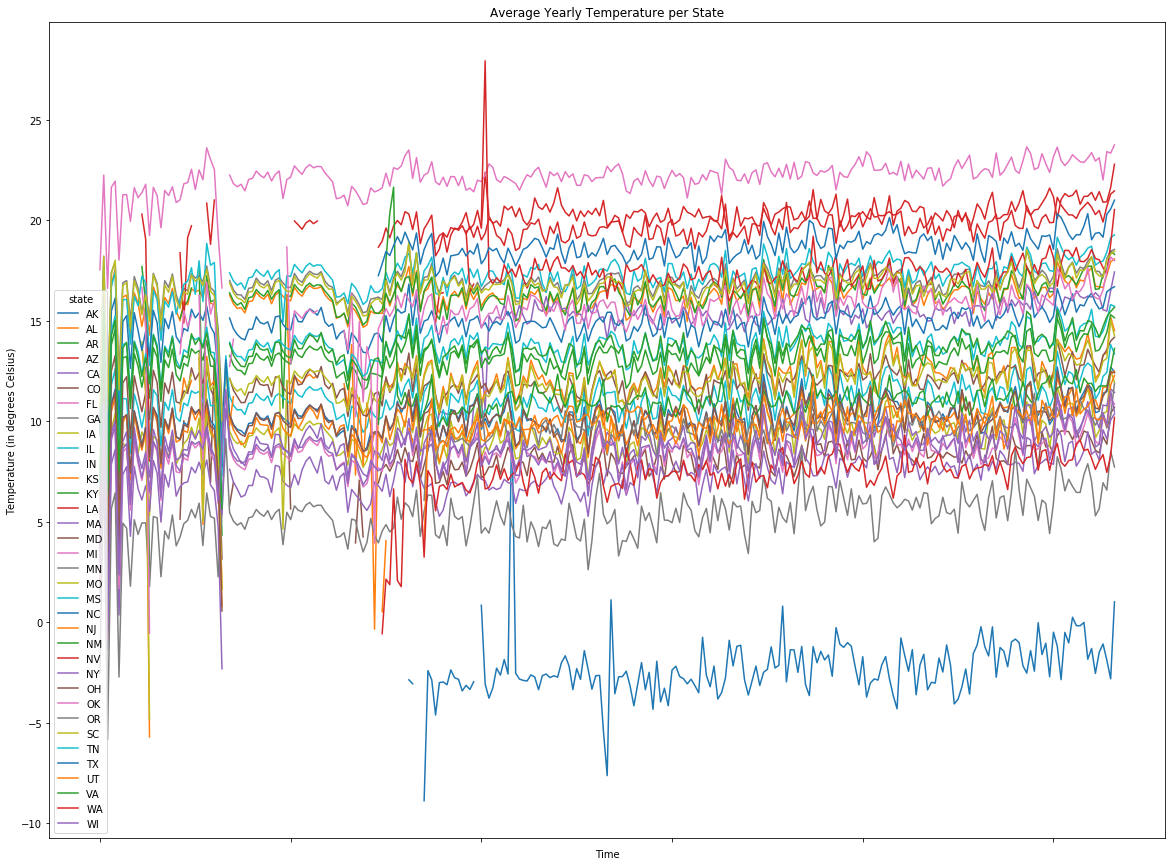

In [25]:
# plot data: average yearly temperature by state
fig, ax = plt.subplots(figsize=(20,15))
temp_county_region.groupby(['year','state']).mean()['AverageTemperature'].unstack().plot(ax=ax)
plt.title('Average Yearly Temperature per State')
plt.xlabel('Time')
plt.ylabel('Temperature (in degrees Celsius)')

Text(0,0.5,'Temperature (in degrees Celsius)')

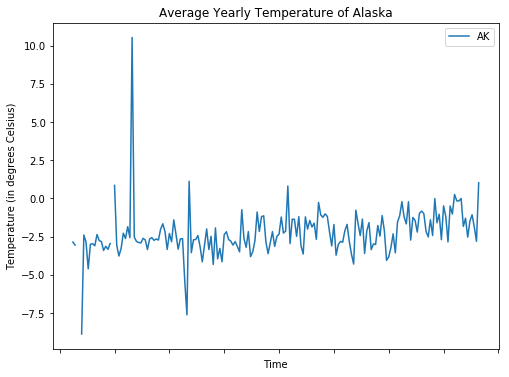

In [26]:
fig, ax = plt.subplots(figsize=(8,6))
temp_county_region.groupby(['year','state']).mean()['AverageTemperature'].unstack().plot(y='AK',ax=ax)
plt.title('Average Yearly Temperature of Alaska')
plt.xlabel('Time')
plt.ylabel('Temperature (in degrees Celsius)')

At a glance, there are definite trends in the data; however this visualization is too overwhelming to make meaningful insights. A deeper look at the values will gives us more insight as to what is happening with the temperature values. There is a clear outlier, or a state with relatively low temperatures, which was the state of Alaska. A graphical check  confirms that Alaska was the state with the low values. This appears normal, given the geographical location of Alaska, being further away from the equator than other states.

### Average yearly temperature, from the earliest fully recorded year to the most recent

I will groupby the datetime to see the counts of average temperature for each date on record. The most recent full year count was 257, thus I will look for the earliest date with the same count. 

In [27]:
# looking for the earliest year that contains the same count as the most recent year (257)
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(temp_county_seasons.groupby(['dt']).count()[['AverageTemperature']].head())

            AverageTemperature
dt                            
1743-11-01                  98
1744-04-01                  98
1744-05-01                  98
1744-06-01                  98
1744-07-01                  98


The earliest full recorded year is 1849 and the most recent full year is 2012. I will use those years, and the data for average temperature across the nation to create boxplots for the data for 1849 and 2012. 

In [53]:
# create a dataframe with the subset of the years 1849 and 2012
subset = temp_county_seasons.copy()
subset = subset.groupby(['state','year']).mean()['AverageTemperature'].unstack()
subset = subset.loc[:,['1849','2012']]
subset[['1849','2012']].plot(kind='box', title='Recorded Temperature Values for the Given Year',showmeans=True)
plt.ylabel('Temperature in degrees Celsius')




year,1743,1744,1745,1750,1751,1752,1753,1754,1755,1756,...,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013
state,,,,,,,,,,,,,,,,,,,,,
AK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.169417,-0.006167,-1.833250,-1.300250,-2.540750,-1.489250,-1.074667,-1.881833,-2.810667,1.018750
AL,9.655800,17.655900,9.835700,16.821818,17.572100,10.953100,16.194783,16.276356,14.068980,16.391511,...,17.038283,16.973800,17.422733,17.653717,16.730567,16.686150,16.673333,17.296717,17.939717,18.083444
AR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,17.215917,17.627417,17.716000,17.731750,16.565000,16.599250,17.324417,17.539000,18.488917,18.308111
AZ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,20.805583,21.194250,21.205167,21.397233,20.999683,21.431000,20.904750,20.927150,21.638017,22.794044
CA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,16.212241,16.127353,16.233172,16.185137,16.402520,16.216013,15.557556,15.484946,16.501552,17.434443
CO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,9.024558,9.521292,9.429042,9.021750,8.570300,8.429783,9.237350,8.863325,10.412233,10.706722
FL,17.543857,22.253054,16.618464,21.646143,21.956857,18.022929,21.269381,21.286302,19.948300,21.628222,...,22.919943,22.884193,23.103474,23.374443,22.953599,23.118901,22.010974,23.424318,23.346078,23.758618
GA,11.647000,18.221875,11.034875,17.400364,17.953563,12.338917,16.896208,17.006000,15.014400,17.210167,...,17.679750,17.588458,17.965875,18.176958,17.474042,17.458292,17.139042,18.112750,18.474667,18.552944
IA,1.667500,11.601313,-0.825750,9.591909,10.400625,1.795750,8.897917,8.768667,5.983100,9.109000,...,10.524896,11.164521,11.604896,10.796750,9.184083,9.541750,10.388083,10.497063,12.524229,11.955972


There is an increase in average temperature across the United States from 1849 to 2012, which can be seen by the green arrow. Each of the five statistical values portrayed by the boxplot are higher in 2012 than in 1849. 

### Average yearly temperature, sorted by region

I will look at how temperature has changed by region. I will use the same two years, 1849 to 2012, and compare the two within each region.

In [29]:
enc_midwest_region = temp_county_region[temp_county_region['region']=='east north central midwest region'][['dt','AverageTemperature']]
enc_1849 = enc_midwest_region[enc_midwest_region['dt'].str.match('1849')].reset_index().rename(index=str, columns={"AverageTemperature": "1849 Average Temperature"})
enc_2012 = enc_midwest_region[enc_midwest_region['dt'].str.match('2012')].reset_index().rename(index=str, columns={"AverageTemperature": "2012 Average Temperature"})

esc_south_region = temp_county_region[temp_county_region['region']=='east south central south region'][['dt','AverageTemperature']]
esc_1849 = esc_south_region[esc_south_region['dt'].str.match('1849')].reset_index().rename(index=str, columns={"AverageTemperature": "1849 Average Temperature"})
esc_2012 = esc_south_region[esc_south_region['dt'].str.match('2012')].reset_index().rename(index=str, columns={"AverageTemperature": "2012 Average Temperature"})

mid_northeast_region = temp_county_region[temp_county_region['region']=='midatlantic northeast region'][['dt','AverageTemperature']]
mid_1849 = mid_northeast_region[mid_northeast_region['dt'].str.match('1849')].reset_index().rename(index=str, columns={"AverageTemperature": "1849 Average Temperature"})
mid_2012 = mid_northeast_region[mid_northeast_region['dt'].str.match('2012')].reset_index().rename(index=str, columns={"AverageTemperature": "2012 Average Temperature"})

mt_west_region = temp_county_region[temp_county_region['region']=='mountain west region'][['dt','AverageTemperature']]
mt_1849 = mt_west_region[mt_west_region['dt'].str.match('1849')].reset_index().rename(index=str, columns={"AverageTemperature": "1849 Average Temperature"})
mt_2012 = mt_west_region[mt_west_region['dt'].str.match('2012')].reset_index().rename(index=str, columns={"AverageTemperature": "2012 Average Temperature"})

ne_northeast_region = temp_county_region[temp_county_region['region']=='new england northeast region'][['dt','AverageTemperature']]
ne_1849 = ne_northeast_region[ne_northeast_region['dt'].str.match('1849')].reset_index().rename(index=str, columns={"AverageTemperature": "1849 Average Temperature"})
ne_2012 = ne_northeast_region[ne_northeast_region['dt'].str.match('2012')].reset_index().rename(index=str, columns={"AverageTemperature": "2012 Average Temperature"})

pac_west_region = temp_county_region[temp_county_region['region']=='pacific west region'][['dt','AverageTemperature']]
pac_1849 = pac_west_region[pac_west_region['dt'].str.match('1849')].reset_index().rename(index=str, columns={"AverageTemperature": "1849 Average Temperature"})
pac_2012 = pac_west_region[pac_west_region['dt'].str.match('2012')].reset_index().rename(index=str, columns={"AverageTemperature": "2012 Average Temperature"})

sa_south_region = temp_county_region[temp_county_region['region']=='south atlantic south region'][['dt','AverageTemperature']]
sa_1849 = sa_south_region[sa_south_region['dt'].str.match('1849')].reset_index().rename(index=str, columns={"AverageTemperature": "1849 Average Temperature"})
sa_2012 = sa_south_region[sa_south_region['dt'].str.match('2012')].reset_index().rename(index=str, columns={"AverageTemperature": "2012 Average Temperature"})

wnc_midwest_region = temp_county_region[temp_county_region['region']=='west north central midwest region'][['dt','AverageTemperature']]
wnc_1849 = wnc_midwest_region[wnc_midwest_region['dt'].str.match('1849')].reset_index().rename(index=str, columns={"AverageTemperature": "1849 Average Temperature"})
wnc_2012 = wnc_midwest_region[wnc_midwest_region['dt'].str.match('2012')].reset_index().rename(index=str, columns={"AverageTemperature": "2012 Average Temperature"})

wsc_south_region = temp_county_region[temp_county_region['region']=='west south central south region'][['dt','AverageTemperature']]
wsc_1849 = wsc_south_region[wsc_south_region['dt'].str.match('1849')].reset_index().rename(index=str, columns={"AverageTemperature": "1849 Average Temperature"})
wsc_2012 = wsc_south_region[wsc_south_region['dt'].str.match('2012')].reset_index().rename(index=str, columns={"AverageTemperature": "2012 Average Temperature"})


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



Text(0.5,1,'West South Central')

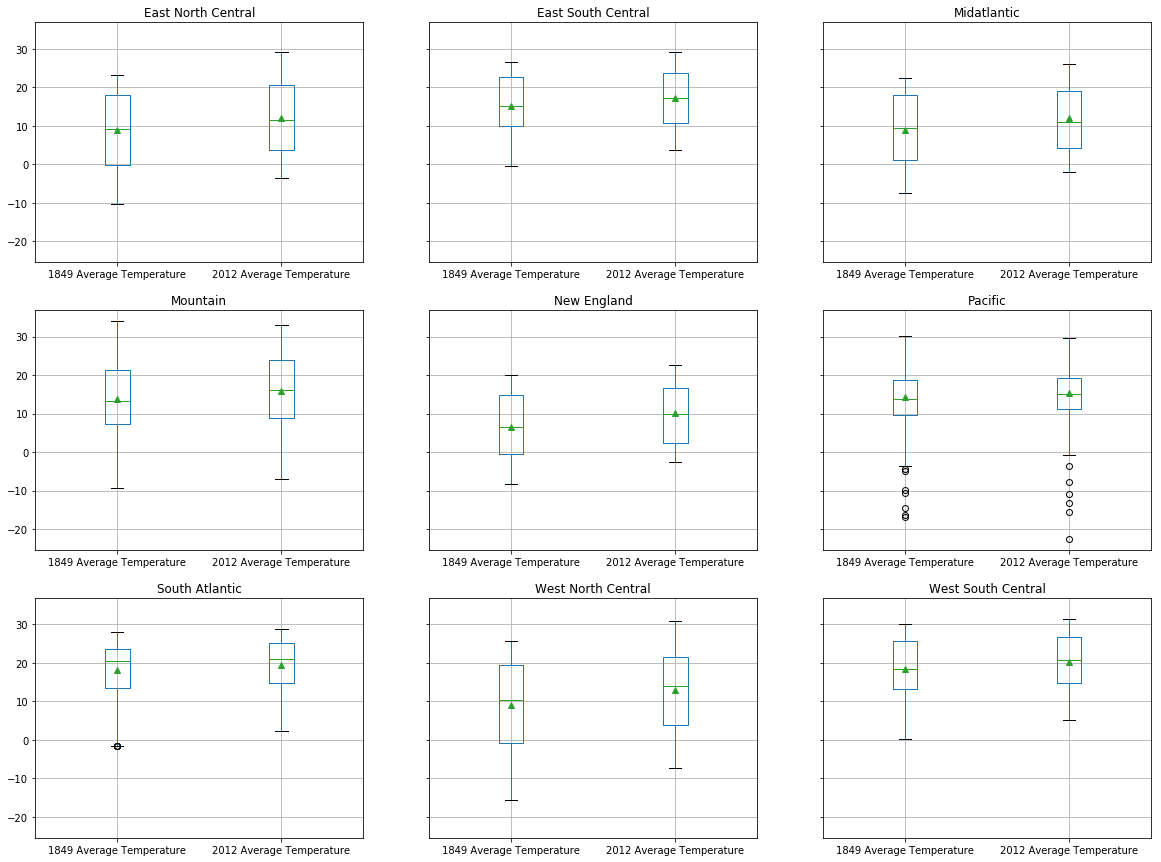

In [30]:
fig, ax = plt.subplots(3,3, sharey='all',figsize=(20,15))

enc = pd.concat([enc_1849,enc_2012],axis=1)[['1849 Average Temperature','2012 Average Temperature']]
enc.boxplot(ax=ax[0,0], showmeans=True)
ax[0,0].set_title('East North Central')

esc = pd.concat([esc_1849,esc_2012],axis=1)[['1849 Average Temperature','2012 Average Temperature']]
esc.boxplot(ax=ax[0,1], showmeans=True)
ax[0,1].set_title('East South Central')

mid = pd.concat([mid_1849,mid_2012],axis=1)[['1849 Average Temperature','2012 Average Temperature']]
mid.boxplot(ax=ax[0,2], showmeans=True)
ax[0,2].set_title('Midatlantic')

mt = pd.concat([mt_1849,mt_2012],axis=1)[['1849 Average Temperature','2012 Average Temperature']]
mt.boxplot(ax=ax[1,0], showmeans=True)
ax[1,0].set_title('Mountain')

ne = pd.concat([ne_1849,ne_2012],axis=1)[['1849 Average Temperature','2012 Average Temperature']]
ne.boxplot(ax=ax[1,1], showmeans=True)
ax[1,1].set_title('New England')

pac = pd.concat([pac_1849,pac_2012],axis=1)[['1849 Average Temperature','2012 Average Temperature']]
pac.boxplot(ax=ax[1,2], showmeans=True)
ax[1,2].set_title('Pacific')

sa = pd.concat([sa_1849,sa_2012],axis=1)[['1849 Average Temperature','2012 Average Temperature']]
sa.boxplot(ax=ax[2,0], showmeans=True)
ax[2,0].set_title('South Atlantic')

wnc = pd.concat([wnc_1849,wnc_2012],axis=1)[['1849 Average Temperature','2012 Average Temperature']]
wnc.boxplot(ax=ax[2,1], showmeans=True)
ax[2,1].set_title('West North Central')

wsc = pd.concat([wsc_1849,wsc_2012],axis=1)[['1849 Average Temperature','2012 Average Temperature']]
wsc.boxplot(ax=ax[2,2], showmeans=True)
ax[2,2].set_title('West South Central')


For each of the nine divisions, it can be seen that the mean temperature in 1849 is lower than that of 2012.  All the regions recorded have a positive change in temperature, which does follow my hypothesis that temperatures have been increasing over time.

### Average yearly temperature, sorted by season


I will look at the seasons (Spring, Summer, Fall, Winter) to see how temperature is changing depending on the time of year. Since generally the summer time is the hottest and the winter is the coldest, sorting by season and then determining the difference may provide more useful insight how temperature is changing yearly, around the same time of year. 


In [31]:
seasons_df = temp_county_region.copy()
seasons_df = seasons_df[['season','state','region','year','AverageTemperature']]
seasons_df = seasons_df.groupby(['season','year']).mean().unstack('season')
#seasons_df

Text(0,0.5,'Temperature (in degrees Celsius)')

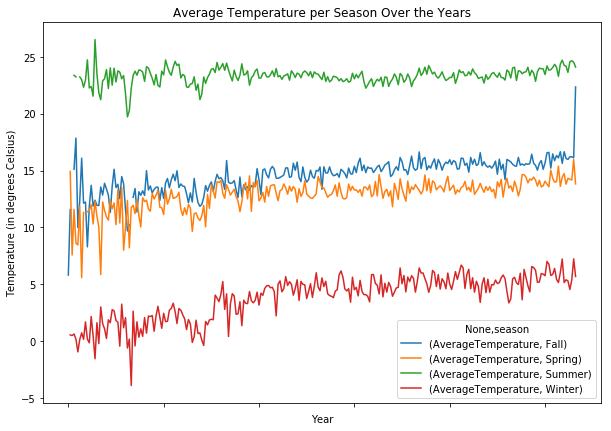

In [32]:
# temperature over time by season
fig, ax = plt.subplots(figsize=(10,7))
seasons_df.plot(ax=ax)
plt.title('Average Temperature per Season Over the Years')
plt.xlabel('Year')
plt.ylabel('Temperature (in degrees Celsius)')


From the temperature over time, separated by seasons, the trend follows with what was predicted. That the summertime has the hottest temperatures and the winter has the lowest temperatures. Fall is slightly hotter than spring, but the temperatures fall between winter and summer. Additionally, it is clear that during the winter time, there has been a definite increase in temperature. To gain more insight, I will examine the change in temperature from the beginning to end, the same as before when the data was sorted by state or region. 


Text(0,0.5,'Temperature in degrees Celsius')

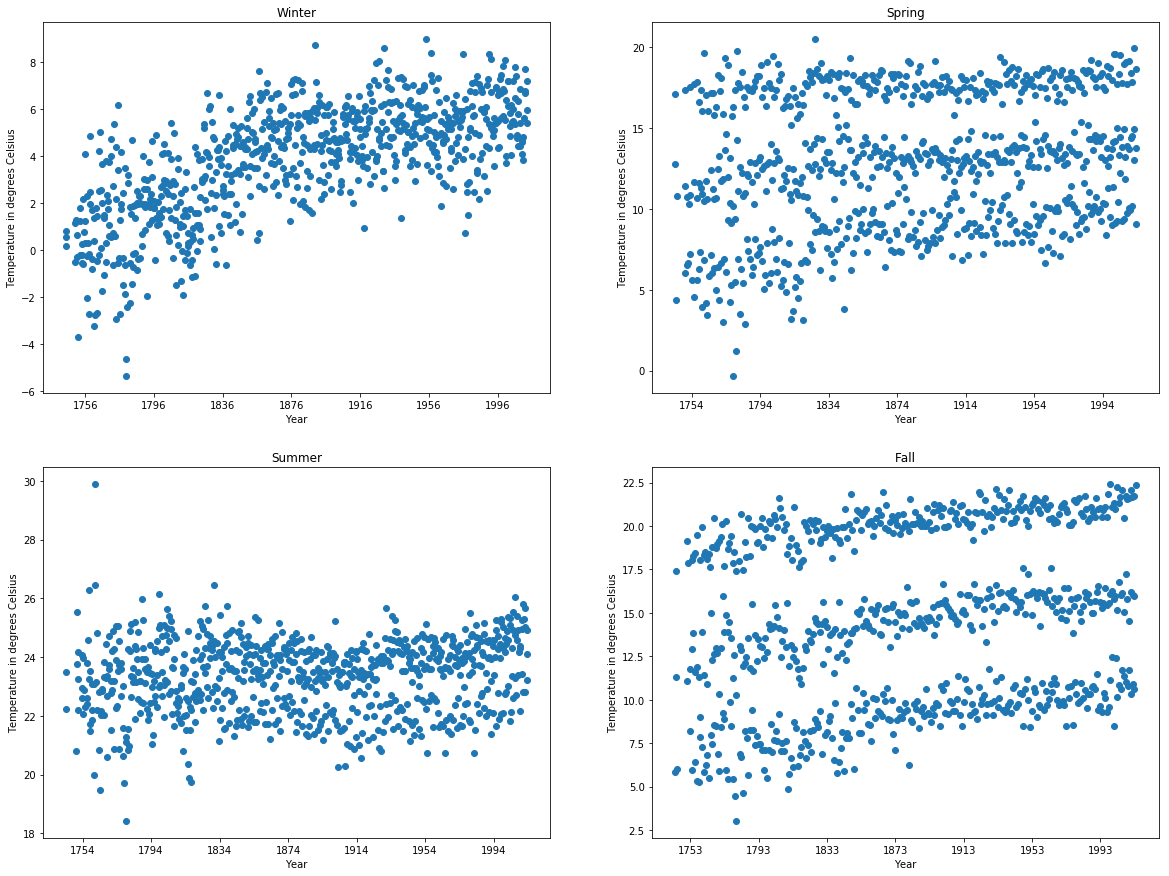

In [33]:
fig, ax = plt.subplots(2,2,figsize=(20,15))

winter = temp_county_region[temp_county_region.season == 'Winter'].groupby('dt').mean()[['AverageTemperature']].reset_index()
winter['date'] = winter['dt'].astype('datetime64[ns]')
ax[0,0].scatter(winter['date'].tolist() ,winter['AverageTemperature'].tolist())
ax[0,0].set_title('Winter')   
ax[0,0].set_xlabel('Year')
ax[0,0].set_ylabel('Temperature in degrees Celsius')
           
spring = temp_county_region[temp_county_region.season == 'Spring'].groupby('dt').mean()[['AverageTemperature']].reset_index()
spring['date'] = spring['dt'].astype('datetime64[ns]')
ax[0,1].scatter(spring['date'].tolist() ,spring['AverageTemperature'].tolist())        
ax[0,1].set_title('Spring')
ax[0,1].set_xlabel('Year')
ax[0,1].set_ylabel('Temperature in degrees Celsius')

summer = temp_county_region[temp_county_region.season == 'Summer'].groupby('dt').mean()[['AverageTemperature']].reset_index()
summer['date'] = summer['dt'].astype('datetime64[ns]')
ax[1,0].scatter(summer['date'].tolist() ,summer['AverageTemperature'].tolist())
ax[1,0].set_title('Summer')
ax[1,0].set_xlabel('Year')
ax[1,0].set_ylabel('Temperature in degrees Celsius')

fall = temp_county_region[temp_county_region.season == 'Fall'].groupby('dt').mean()[['AverageTemperature']].reset_index()
fall['date'] = fall['dt'].astype('datetime64[ns]')
ax[1,1].scatter(fall['date'].tolist() ,fall['AverageTemperature'].tolist())
ax[1,1].set_title('Fall')  
ax[1,1].set_xlabel('Year')
ax[1,1].set_ylabel('Temperature in degrees Celsius')
           

These four scatter plots show the correlation of date and average temperature. Each of the temperature values were averaged for a given date, and each season is portrayed. Winter shows a positive correlation of time and temperature, while summer does not show much correlation. Both spring and fall have three bands, which can be attributed to the three months for the given season. Since spring and fall are transition periods between hot and cold seasons, the bands make sense. Fall shows some positive correlation within each band, as time goes on, temperature is rising, and a similar trend can be seen with the lower temperatures in spring. These correlations will be useful for further statistical analysis and linear regression. 

### Average yearly temperature, sorted by month

I will now explore temperature as it changes by month, which is essentially a more detailed view of the seasons. 

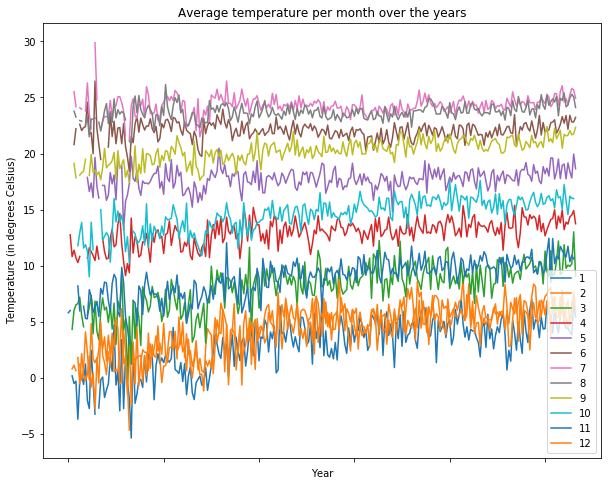

In [34]:
# temperature over time by month
fig, ax = plt.subplots(figsize=(10,8))
temp_county_region.groupby(['year','month']).mean()['AverageTemperature'].unstack().plot(ax=ax)
plt.title('Average temperature per month over the years')
plt.xlabel('Year')
plt.ylabel('Temperature (in degrees Celsius)')
plt.legend()

It can be observed that the summer months (July, August, and June) have the highest average temperature over the years and the winter months (January, February, and December) have the lowest temperatures. This follows the expected trend, but the question of is the average temperature increasing over time is still unknown, without some statistical analysis. 

Text(0,0.5,'Temperature in degrees Celsius')

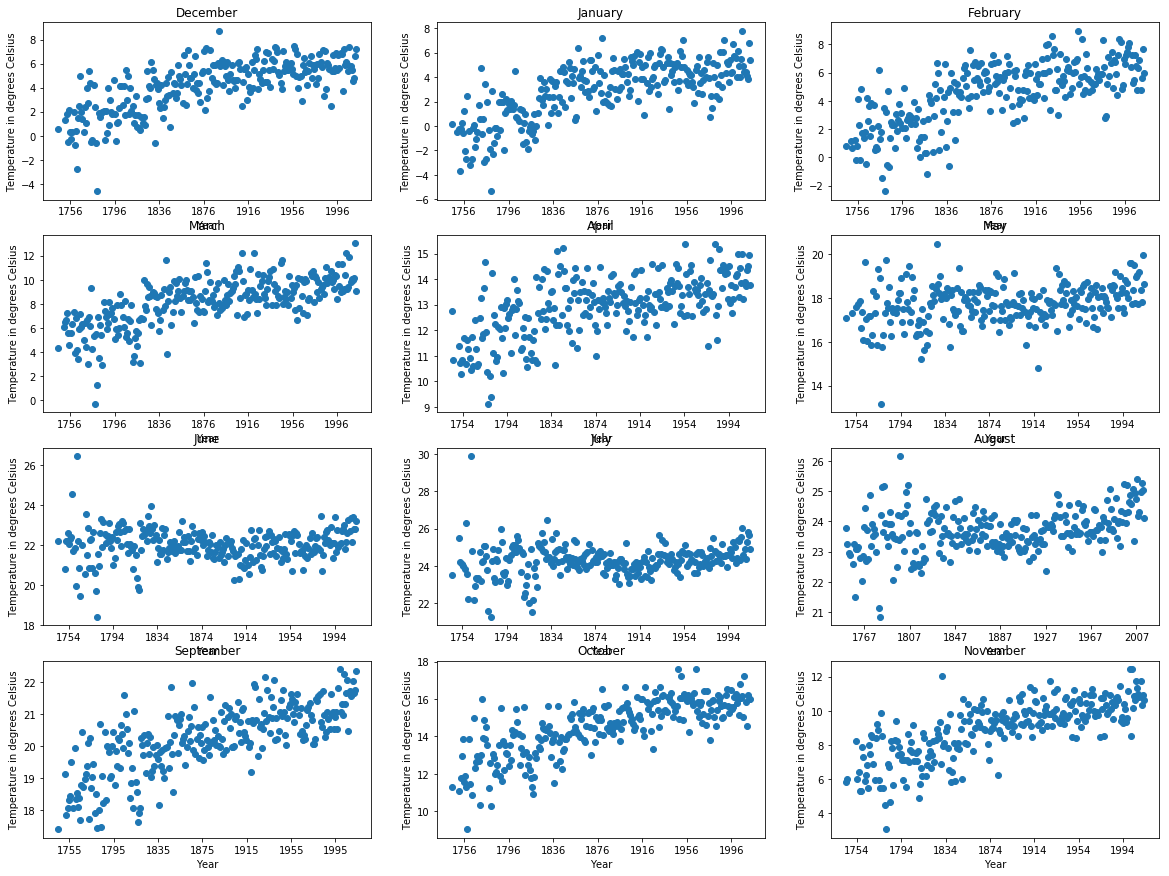

In [35]:
fig, ax = plt.subplots(4,3,figsize=(20,15))

dec = temp_county_region[temp_county_region.month == 12].groupby('dt').mean()[['AverageTemperature']].reset_index()
dec['date'] = dec['dt'].astype('datetime64[ns]')
ax[0,0].scatter(dec['date'].tolist() ,dec['AverageTemperature'].tolist())
ax[0,0].set_title('December')    
ax[0,0].set_xlabel('Year')
ax[0,0].set_ylabel('Temperature in degrees Celsius')
                    
jan = temp_county_region[temp_county_region.month == 1].groupby('dt').mean()[['AverageTemperature']].reset_index()
jan['date'] = jan['dt'].astype('datetime64[ns]')
ax[0,1].scatter(jan['date'].tolist() ,jan['AverageTemperature'].tolist())
ax[0,1].set_title('January')       
ax[0,1].set_xlabel('Year')
ax[0,1].set_ylabel('Temperature in degrees Celsius')

feb = temp_county_region[temp_county_region.month == 2].groupby('dt').mean()[['AverageTemperature']].reset_index()
feb['date'] = feb['dt'].astype('datetime64[ns]')
ax[0,2].scatter(feb['date'].tolist() ,feb['AverageTemperature'].tolist())
ax[0,2].set_title('February')       
ax[0,2].set_xlabel('Year')
ax[0,2].set_ylabel('Temperature in degrees Celsius')


mar = temp_county_region[temp_county_region.month == 3].groupby('dt').mean()[['AverageTemperature']].reset_index()
mar['date'] = mar['dt'].astype('datetime64[ns]')
ax[1,0].scatter(mar['date'].tolist() ,mar['AverageTemperature'].tolist())
ax[1,0].set_title('March')           
ax[1,0].set_xlabel('Year')
ax[1,0].set_ylabel('Temperature in degrees Celsius')
                    
apr = temp_county_region[temp_county_region.month == 4].groupby('dt').mean()[['AverageTemperature']].reset_index()
apr['date'] = apr['dt'].astype('datetime64[ns]')
ax[1,1].scatter(apr['date'].tolist() ,apr['AverageTemperature'].tolist())
ax[1,1].set_title('April')       
ax[1,1].set_xlabel('Year')
ax[1,1].set_ylabel('Temperature in degrees Celsius')

may = temp_county_region[temp_county_region.month == 5].groupby('dt').mean()[['AverageTemperature']].reset_index()
may['date'] = may['dt'].astype('datetime64[ns]')
ax[1,2].scatter(may['date'].tolist() ,may['AverageTemperature'].tolist())
ax[1,2].set_title('May')
ax[1,2].set_xlabel('Year')
ax[1,2].set_ylabel('Temperature in degrees Celsius')


jun = temp_county_region[temp_county_region.month == 6].groupby('dt').mean()[['AverageTemperature']].reset_index()
jun['date'] = jun['dt'].astype('datetime64[ns]')
ax[2,0].scatter(jun['date'].tolist() ,jun['AverageTemperature'].tolist())
ax[2,0].set_title('June')           
ax[2,0].set_xlabel('Year')
ax[2,0].set_ylabel('Temperature in degrees Celsius')
                    
jul = temp_county_region[temp_county_region.month == 7].groupby('dt').mean()[['AverageTemperature']].reset_index()
jul['date'] = jul['dt'].astype('datetime64[ns]')
ax[2,1].scatter(jul['date'].tolist() ,jul['AverageTemperature'].tolist())
ax[2,1].set_title('July')       
ax[2,1].set_xlabel('Year')
ax[2,1].set_ylabel('Temperature in degrees Celsius')

aug = temp_county_region[temp_county_region.month == 8].groupby('dt').mean()[['AverageTemperature']].reset_index()
aug['date'] = aug['dt'].astype('datetime64[ns]')
ax[2,2].scatter(aug['date'].tolist() ,aug['AverageTemperature'].tolist())
ax[2,2].set_title('August')
ax[2,2].set_xlabel('Year')
ax[2,2].set_ylabel('Temperature in degrees Celsius')


sep = temp_county_region[temp_county_region.month == 9].groupby('dt').mean()[['AverageTemperature']].reset_index()
sep['date'] = sep['dt'].astype('datetime64[ns]')
ax[3,0].scatter(sep['date'].tolist() ,sep['AverageTemperature'].tolist())
ax[3,0].set_title('September')
ax[3,0].set_xlabel('Year')
ax[3,0].set_ylabel('Temperature in degrees Celsius')
                    
octo = temp_county_region[temp_county_region.month == 10].groupby('dt').mean()[['AverageTemperature']].reset_index()
octo['date'] = octo['dt'].astype('datetime64[ns]')
ax[3,1].scatter(octo['date'].tolist() ,octo['AverageTemperature'].tolist())
ax[3,1].set_title('October')    
ax[3,1].set_xlabel('Year')
ax[3,1].set_ylabel('Temperature in degrees Celsius')

nov = temp_county_region[temp_county_region.month == 11].groupby('dt').mean()[['AverageTemperature']].reset_index()
nov['date'] = nov['dt'].astype('datetime64[ns]')
ax[3,2].scatter(nov['date'].tolist() ,nov['AverageTemperature'].tolist())
ax[3,2].set_title('November')
ax[3,2].set_xlabel('Year')
ax[3,2].set_ylabel('Temperature in degrees Celsius')

These are the correlations of average temperature over datetime for each month. Most months, except summer, show a positive, linear correlation. However, around May-August, there is a curving feature where the temperature around the late 1800s starts to decrease. These correlations will be further analyzed, but they serve useful to show that in general, temperature has been increasing with time.

### Disaster data

Part of the hypothesis is to see if natural disasters in the United States have increased due to temperature changes. To examine the disaster side, I will look at the disaster data frame and see how disasters have changed over time. 

In [36]:
# create a copy of the disaster data, extracting the columns with the necessary data
disaster = disaster_county.copy()
disaster = disaster[['Declaration Type','Declaration Date','Year','State','County','Disaster Type']]
disaster.head()

,Declaration Type,Declaration Date,Year,State,County,Disaster Type
0,Disaster,05/02/1953,1953,GA,NaN,Tornado
1,Disaster,05/15/1953,1953,TX,NaN,Tornado
2,Disaster,05/29/1953,1953,LA,NaN,Flood
3,Disaster,06/02/1953,1953,MI,NaN,Tornado
4,Disaster,06/06/1953,1953,MT,NaN,Flood


Looking at the disaster DataFrame, there are repeats in the disasters since the data is recorded at the county level. However, it is possible that the disaster was across multiple counties. To account for the duplicates, I will drop any duplicate with the same Declaration date, disaster type, and state. 

In [37]:
disaster_unique = disaster.drop_duplicates(subset=['Declaration Date', 'Disaster Type', 'State']) 
disaster_unique.head()

,Declaration Type,Declaration Date,Year,State,County,Disaster Type
0,Disaster,05/02/1953,1953,GA,NaN,Tornado
1,Disaster,05/15/1953,1953,TX,NaN,Tornado
2,Disaster,05/29/1953,1953,LA,NaN,Flood
3,Disaster,06/02/1953,1953,MI,NaN,Tornado
4,Disaster,06/06/1953,1953,MT,NaN,Flood


In [38]:
# count total number of disasters, see which disasters are most prevalent
disaster_unique.groupby('Disaster Type').agg('count')['Declaration Type'].sort_values(ascending=False).head()

Disaster Type
Storm        919
Flood        772
Fire         680
Hurricane    313
Tornado      163
Name: Declaration Type, dtype: int64

The first five disasters with the most occurences in the United States are: storms, floods, fires, hurricanes, and tornados. I will focus on these disasters to examine the trends in the data, since they make up most of the data.

### Joined temperature and disaster data

To view correlations between temperature and disaster I must join the disaster and temperature data. I will first join on state and then join the nearest dates, using pd.merge_asof. 

In [39]:
# copy of disaster data to organize for the join
disasterdf = disaster.copy()
disasterdf['date'] = disasterdf['Declaration Date'].astype('datetime64[ns]')
disasterdf = disasterdf.drop_duplicates(subset=['Declaration Date', 'Disaster Type', 'State','Year']) 
disasterdf.head()

# copy of temperature data to organize for the join
tempdf = temp_county_region.copy()
tempdf['date'] = tempdf['dt'].astype('datetime64[ns]')
tempdf = tempdf[['date','dt','AverageTemperature','state','county','year','season','month', 'region']].sort_values('date')
tempdf.head()

# nearest join on date (with a left join on state first)
joindf = pd.merge_asof(disasterdf, tempdf, on='date',left_by='State',right_by='state',direction='nearest').dropna()


In [40]:
# removing rows where the join dates did not match since the disaster data only went up to Sept 2013
joindf = joindf[joindf['date']<='2013-09-30']
joindf.head()

,Declaration Type,Declaration Date,Year,State,County,Disaster Type,date,dt,AverageTemperature,state,county,year,season,month,region
89,Disaster,01/29/1959,1959,IN,Clay County,Flood,1959-01-29,1959-02-01,0.961,IN,Decatur,1959,Winter,2.0,east north central midwest region
181,Disaster,12/24/1964,1964,CA,Alpine County,Flood,1964-12-24,1965-01-01,13.677,CA,San Diego,1965,Winter,1.0,pacific west region
182,Disaster,12/24/1964,1964,OR,Baker County,Flood,1964-12-24,1965-01-01,3.656,OR,Lane,1965,Winter,1.0,pacific west region
183,Disaster,12/29/1964,1964,WA,Asotin County,Flood,1964-12-29,1965-01-01,1.133,WA,King,1965,Winter,1.0,pacific west region
185,Disaster,01/18/1965,1965,NV,Douglas County,Flood,1965-01-18,1965-02-01,8.848,NV,Clark,1965,Winter,2.0,mountain west region


In [41]:
# groupby to get the disaster count and average temperature for the scatter plot
join_state1 = join_state[['Declaration Date','State','Disaster Type','Year','AverageTemperature','state','year']]
join_state_group = join_state1.groupby(['Year']).agg({'Disaster Type':'count',
                                                      'AverageTemperature':'mean'})
join_state_group.head()

,Disaster Type,AverageTemperature
Year,,
1953,13,14.249234
1954,17,12.873133
1955,18,11.691972
1956,16,12.726184
1957,16,13.351205


Text(0.5,1,'Average Yearly Temperature vs. Disaster Count')

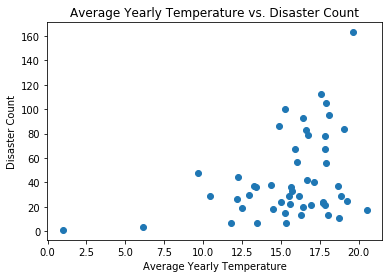

In [42]:
joindf1 = joindf.groupby('Year').agg({'Disaster Type':'count',
                                                      'AverageTemperature':'mean'})

plt.scatter(joindf1['AverageTemperature'], joindf1['Disaster Type'])
plt.xlabel('Average Yearly Temperature')
plt.ylabel('Disaster Count')
plt.title('Average Yearly Temperature vs. Disaster Count')

This scatterplot is the yearly average temperature against the disaster count across the nation. Further statistical analysis will help disclose whether or not there is a correlation.

Furthermore, I will look at specific regions, or other distinct groups of states, and look at the disasters prone to each region. For example, hurricanes occur mostly on the east coast, so I will look at those states and that specific disaster. I will go through the top five disasters (storms, floods, fires, hurricanes, and tornados) and their respective regions. 

### Storms

Text(0.5,1,'Average Yearly Temperature vs. Disaster Count')

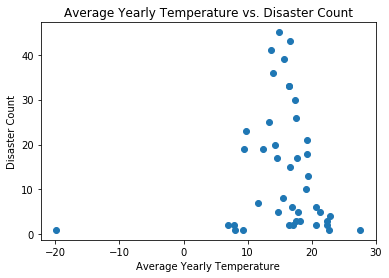

In [43]:
stormdf = joindf[joindf['Disaster Type']=='Storm']
stormdf = stormdf.groupby('Year').agg({'Disaster Type':'count',
                                               'AverageTemperature':'mean'})

plt.scatter(stormdf['AverageTemperature'], stormdf['Disaster Type'])
plt.xlabel('Average Yearly Temperature')
plt.ylabel('Disaster Count')
plt.title('Average Yearly Temperature vs. Disaster Count')

### Floods

In [44]:
flooddf = joindf[(joindf['Disaster Type']=='Flood')&
             (joindf['region'].str.contains('south region'))|
             (joindf['region'].str.contains('northeast region'))|
             (joindf['region'].str.contains('midwest region'))]

Text(0.5,1,'Average Yearly Temperature vs. Disaster Count')

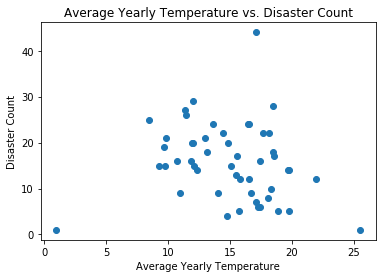

In [45]:
flooddf = flooddf.groupby('Year').agg({'Disaster Type':'count',
                                               'AverageTemperature':'mean'})

plt.scatter(flooddf['AverageTemperature'], flooddf['Disaster Type'])
plt.xlabel('Average Yearly Temperature')
plt.ylabel('Disaster Count')
plt.title('Average Yearly Temperature vs. Disaster Count')

### Fires

In [46]:
firedf = joindf[(joindf['Disaster Type']=='Fire')&
             (joindf['region'].str.contains('west region'))]

Text(0.5,1,'Average Yearly Temperature vs. Disaster Count')

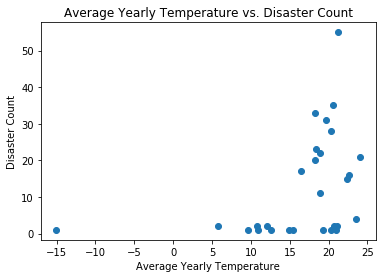

In [47]:
firedf = firedf.groupby('Year').agg({'Disaster Type':'count',
                                               'AverageTemperature':'mean'})

plt.scatter(firedf['AverageTemperature'], firedf['Disaster Type'])
plt.xlabel('Average Yearly Temperature')
plt.ylabel('Disaster Count')
plt.title('Average Yearly Temperature vs. Disaster Count')

### Hurricanes

In [48]:
hurricanedf = joindf[(joindf['Disaster Type']=='Hurricane')&
             (joindf['region'].str.contains('south region')) |
             (joindf['region'].str.contains('northeast region'))]

Text(0.5,1,'Average Yearly Temperature vs. Disaster Count')

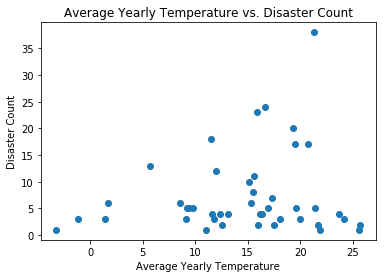

In [49]:
hurricanedf = hurricanedf.groupby('Year').agg({'Disaster Type':'count',
                                               'AverageTemperature':'mean'})

plt.scatter(hurricanedf['AverageTemperature'], hurricanedf['Disaster Type'])
plt.xlabel('Average Yearly Temperature')
plt.ylabel('Disaster Count')
plt.title('Average Yearly Temperature vs. Disaster Count')

### Tornados 

In [50]:
tornadodf = joindf[(joindf['Disaster Type']=='Tornado')&
             (joindf['region'].str.contains('midwest region')) |
             (joindf['region'].str.contains('west south central'))]

Text(0.5,1,'Average Yearly Temperature vs. Disaster Count')

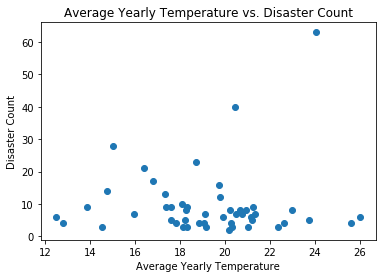

In [51]:
tornadodf = tornadodf.groupby('Year').agg({'Disaster Type':'count',
                                               'AverageTemperature':'mean'})

plt.scatter(tornadodf['AverageTemperature'], tornadodf['Disaster Type'])
plt.xlabel('Average Yearly Temperature')
plt.ylabel('Disaster Count')
plt.title('Average Yearly Temperature vs. Disaster Count')

For each of the five major disasters, there is not an evident correlation between the disaster count and average yearly temperature. With further statistical analysis, we can determine whether or not there is a correlation.